In [48]:
import warnings
warnings.filterwarnings('ignore')

In [83]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
%matplotlib inline
import matplotlib.pyplot as plt

In [50]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Needed for decision tree visualization
import pydotplus
from IPython.display import Image

# Read the CSV and Perform Basic Data Cleaning

In [51]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [52]:
# Load the data
file_path = Path('../Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()
df.to_csv('test.csv')

In [62]:
df_with_dummies = pd.get_dummies(df, columns=['home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'initial_list_status', 'next_pymnt_d', 'application_type', 'hardship_flag', 'debt_settlement_flag'])

In [63]:
df_with_dummies.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,0,1,1,0,1,1


In [72]:
X = df_with_dummies.copy()
X.drop('loan_status', axis = 1, inplace = True)
X.head()
# X = X.values

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
0,10500.0,0.1719,375.35,66000.0,27.24,0.0,0.0,8.0,0.0,1609.0,...,1,1,0,1,0,1,1,0,1,1
1,25000.0,0.2000,929.09,105000.0,20.23,0.0,0.0,17.0,1.0,18368.0,...,1,1,0,1,0,1,1,0,1,1
2,20000.0,0.2000,529.88,56000.0,24.26,0.0,0.0,8.0,0.0,13247.0,...,1,1,0,1,0,1,1,0,1,1
3,10000.0,0.1640,353.55,92000.0,31.44,0.0,1.0,10.0,1.0,17996.0,...,1,1,0,1,0,1,1,0,1,1
4,22000.0,0.1474,520.39,52000.0,18.76,0.0,1.0,14.0,0.0,9091.0,...,1,1,0,1,0,1,1,0,1,1


In [75]:
# y = df['loan_status'].values.reshape(-1,1)
# y[:5]
# type(y)
y = df["loan_status"].ravel()
y[:5]

y = pd.DataFrame(y)
type(y)
y.rename(columns = {0 : 'loan_status'}, inplace = True)
y.head()

,loan_status
0,low_risk
1,low_risk
2,low_risk
3,low_risk
4,low_risk


In [76]:
# X.describe()
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [77]:
type(X)

pandas.core.frame.DataFrame

In [78]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=78)
# # Creating StandardScaler instance
# scaler = StandardScaler()

# # Fitting Standard Scaler
# X_scaler = scaler.fit(X_train)

# # Scaling data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [79]:
X_train[1:3]

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
39432,1000.0,0.1180,33.12,31000.0,13.70,0.0,0.0,6.0,0.0,1150.0,...,0,1,1,0,1,0,1,0,1,1
14198,10000.0,0.1502,238.01,80000.0,23.18,0.0,1.0,12.0,0.0,2444.0,...,0,1,0,1,1,0,1,0,1,1


In [80]:
# implement random oversampling
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                               criterion='gini', max_depth=None,
                               max_features='auto', max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_jobs=1, oob_score=False, random_state=1,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [88]:
y_pred_rf = brf.predict(X_test)

In [91]:
# Confusion matrix
confusion_matrix(y_test, y_pred_rf)

array([[   58,    34],
       [ 1611, 15502]], dtype=int64)

In [89]:
# metrics for balanced random forest classifier
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.03      0.63      0.91      0.07      0.76      0.56        92
   low_risk       1.00      0.91      0.63      0.95      0.76      0.59     17113

avg / total       0.99      0.90      0.63      0.94      0.76      0.59     17205



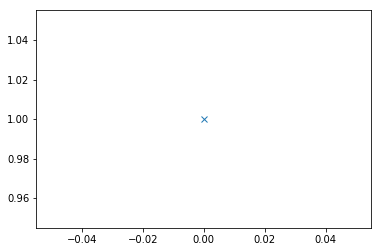

In [84]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve
probs_rf = brf.predict_proba(X_test)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)
plt.plot(recall_rf, precision_rf, marker='x')

In [85]:
# Confusion matrix and accuracy score
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

NameError: name 'predictions' is not defined

In [86]:
# Displaying results with accuracy score
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


NameError: name 'cm_df' is not defined

# Split the Data into Training and Testing

In [6]:
# Create our features
X = # YOUR CODE HERE

# Create our target
y = # YOUR CODE HERE

In [7]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [8]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [9]:
# Split the X and y into X_train, X_test, y_train, y_test
# YOUR CODE HERE

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [10]:
# Resample the training data with the RandomOversampler
# YOUR CODE HERE

BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                oob_score=False, random_state=1, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False)

In [11]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

0.7855052723466922

In [12]:
# Display the confusion matrix
# YOUR CODE HERE

array([[   68,    33],
       [ 1749, 15355]])

In [13]:
# Print the imbalanced classification report
# YOUR CODE HERE

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.04      0.67      0.90      0.07      0.78      0.59       101
   low_risk       1.00      0.90      0.67      0.95      0.78      0.62     17104

avg / total       0.99      0.90      0.67      0.94      0.78      0.62     17205



In [14]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE

loan_amnt: (0.09175752102205247)
int_rate: (0.06410003199501778)
installment: (0.05764917485461809)
annual_inc: (0.05729679526683975)
dti: (0.05174788106507317)
delinq_2yrs: (0.031955619175665397)
inq_last_6mths: (0.02353678623968216)
open_acc: (0.017078915518993903)
pub_rec: (0.017014861224701222)
revol_bal: (0.016537957646730293)
total_acc: (0.016169718411077325)
out_prncp: (0.01607049983545137)
out_prncp_inv: (0.01599866290723441)
total_pymnt: (0.015775537221600675)
total_pymnt_inv: (0.01535560674178928)
total_rec_prncp: (0.015029265003541079)
total_rec_int: (0.014828006488636946)
total_rec_late_fee: (0.01464881608833323)
recoveries: (0.014402430445752665)
collection_recovery_fee: (0.014318832248876989)
last_pymnt_amnt: (0.013519867193755364)
collections_12_mths_ex_med: (0.013151520216882331)
policy_code: (0.013101578263049833)
acc_now_delinq: (0.012784600558682344)
tot_coll_amt: (0.012636608914961465)
tot_cur_bal: (0.012633464965390648)
open_acc_6m: (0.012406321468566728)
open_act_

### Easy Ensemble AdaBoost Classifier

In [15]:
# Train the Classifier
# YOUR CODE HERE

EasyEnsembleClassifier(base_estimator=None, n_estimators=100, n_jobs=1,
            random_state=1, replacement=False, sampling_strategy='auto',
            verbose=0, warm_start=False)

In [16]:
# Calculated the balanced accuracy score
# YOUR CODE HERE

0.9316600714093861

In [17]:
# Display the confusion matrix
# YOUR CODE HERE

array([[   93,     8],
       [  983, 16121]])

In [18]:
# Print the imbalanced classification report
# YOUR CODE HERE

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.09      0.92      0.94      0.16      0.93      0.87       101
   low_risk       1.00      0.94      0.92      0.97      0.93      0.87     17104

avg / total       0.99      0.94      0.92      0.97      0.93      0.87     17205

